In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP', 'NC']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(441, 34716)
(441,)
[1 1 0 1 1]


In [4]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,  
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

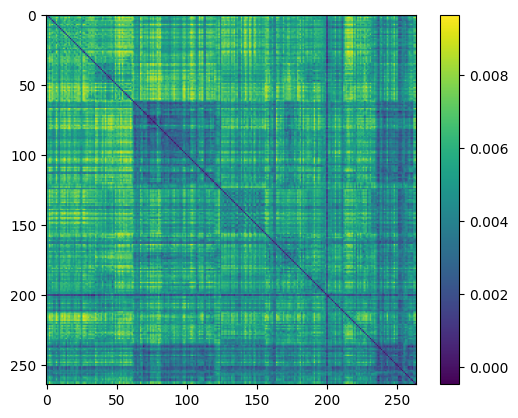

In [6]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt 

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

pca = PCA(n_components=150).fit(x)
plt.imshow(remap(vec2mat(pca.components_[0])))
plt.colorbar()
plt.show()

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def rmse(a, b):
    return np.mean((a-b)**2, axis=1)**0.5

for _ in range(10):

    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

    aa = xtr[np.where(ytr == 1)[0]]
    ca = xtr[np.where(ytr == 0)[0]]

    aapca = PCA(n_components=150).fit(aa)
    aatr = aapca.transform(xtr)
    aatrinv = aapca.inverse_transform(aatr)
    aat = aapca.transform(xt)
    aatinv = aapca.inverse_transform(aat)

    capca = PCA(n_components=150).fit(ca)
    catr = capca.transform(xtr)
    catrinv = capca.inverse_transform(catr)
    cat = capca.transform(xt)
    catinv = capca.inverse_transform(cat)

    aatrerr = rmse(aatrinv, xtr)
    catrerr = rmse(catrinv, xtr)
    aaterr = rmse(aatinv, xt)
    caterr = rmse(catinv, xt)

    print(np.mean((aaterr < caterr) == (yt == 1)))

    a = aapca.transform(xtr)
    b = np.stack([aatrerr, catrerr], axis=1)
    c = capca.transform(xtr)

    aa = aapca.transform(xt)
    bb = np.stack([aaterr, caterr], axis=1)
    cc = capca.transform(xt)

    xxtr = np.concatenate([a,c], axis=1)
    xxt = np.concatenate([aa,cc], axis=1)

    clf = LogisticRegression(max_iter=1000).fit(xxtr, ytr)
    yhat = clf.predict_proba(xxt)
    print(np.mean((yhat[:,1] > yhat[:,0]) == yt))
    
    yhat[np.where(aaterr < caterr)[0],1] += 0.3
    yhat[np.where(aaterr > caterr)[0],0] += 0.3
#     print(yhat)
    print(np.mean((yhat[:,1] > yhat[:,0]) == yt))
    
    clf = LogisticRegression(max_iter=1000).fit(xtr, ytr)
    yhat = clf.predict(xt)
    print(np.mean(yhat == yt))
    
    print('---')

# reg = LinearRegression().fit(xxtr, ytr_np)
# yhat = reg.predict(xxtr)
# print(rmse_np(yhat, ytr_np))
# yhat = reg.predict(xxt)
# print(rmse_np(yhat, yt_np))

# clf = LogisticRegression(max_iter=1000).fit(xxtr, ytr)
# yhat = clf.predict(xxtr)
# print(np.mean((yhat == ytr).astype('int')))

# yhat = clf.predict(xxt)
# print(np.mean((yhat == yt).astype('int')))

0.7078651685393258
0.7415730337078652
0.7528089887640449
0.7528089887640449
---
0.6292134831460674
0.6404494382022472
0.6292134831460674
0.6853932584269663
---
0.6966292134831461
0.7191011235955056
0.7528089887640449


KeyboardInterrupt: 

In [81]:
np.where(aaterr < caterr)[0]

array([  2,  11,  13,  15,  16,  54,  63,  81,  87,  92,  93, 110, 115,
       116, 136, 147, 157, 161, 175, 183, 188, 202, 219])